# Replicate results on the Poker DVS dataset for the Grimaldi et al. 2021 paper

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

from network import network
from tools import get_loader, get_dataset_info, fit_MLR, predict_MLR, score_classif_events, score_classif_time, fit_histo
import os, tonic

def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS


## TODO
- classification with histograms
- classification with MLR
- classification when trying different clustering
- classification as a function of jitter

## Information about the dataset

number of samples in the trainset: 48
number of samples in the testset: 20
----------------------------------------
mean value for the recording time: 17.4 ms
mean value for the number of events: 3050
mean value for the interspike interval: 29 us
----------------------------------------


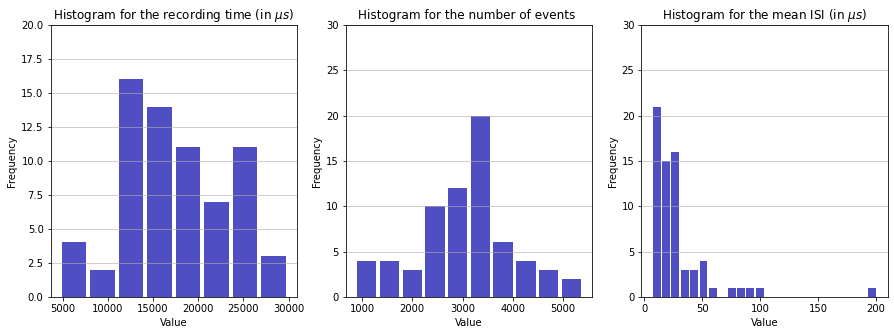

In [12]:
trainset = tonic.datasets.POKERDVS(save_to='../../Data', train = True, transform = tonic.transforms.NumpyAsType(int))
testset = tonic.datasets.POKERDVS(save_to='../../Data', train = False, transform = tonic.transforms.NumpyAsType(int))
get_dataset_info(trainset,testset)

## Define the hyperparameters of the network

In [13]:
#for poker DVS
sensor_size = trainset.sensor_size
name = 'homhots'
tau = (0.3*2,0.3*4,0.3*8)
homeo = (2,.5)
timestr = '2022-01-06_poker'

loading a network with name:
 ../Records/models/2022-01-06_poker_homhots_(2, 0.5)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl


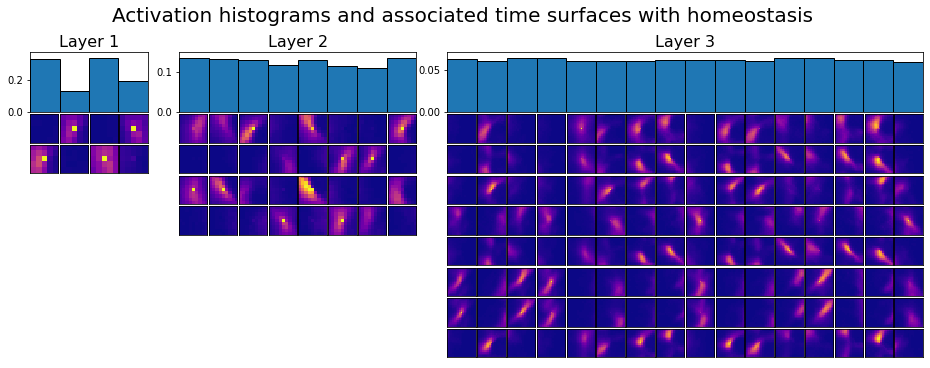

In [14]:
hots = network(name = name, tau = tau, homeo = homeo, timestr = timestr, camsize=(sensor_size[0], sensor_size[1]))
loader = get_loader(trainset)
hots.running(loader, trainset.ordering, trainset.classes, learn=True, train=True)
hots.plotlayer();

# Online classification performance

In [23]:
tau_cla = 15
hots.running(loader, trainset.ordering, trainset.classes, train=True)
model, loss = fit_MLR(hots, tau_cla)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_homhots_(2, 0.5)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of training samples: 48
device -> cuda - num workers -> 0
loss for epoch number 0: 0.6418738302236057
loss for epoch number 1: 0.10459917297249859
loss for epoch number 2: 0.020981904981378127
loss for epoch number 3: 0.019181908805853652
loss for epoch number 4: 0.005957450226475971
loss for epoch number 5: 0.011022805941000685
loss for epoch number 6: 0.006219719434119377
loss for epoch number 7: 0.009218040662793301
loss for epoch number 8: 0.012853451924940796
loss for epoch number 9: 0.005381259014900373
loss for epoch number 10: 0.00928662875595689
loss for epoch number 11: 0.01759646045155429
loss for epoch number 12: 0.006398060135129114
loss for epoch number 13: 0.008193649349837599
loss for epoch number 14: 0.00490568860782914
loss for epoch number 15: 0.009198771968842447
loss for epoch number 16: 0.0078409052973948

this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_homhots_(2, 0.5)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of testing samples: 20
device -> cuda - num workers -> 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.39it/s]


Mean accuracy: 98.0%


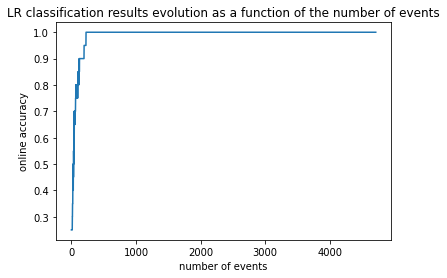

In [24]:
loader = get_loader(testset)
hots.running(loader, trainset.ordering, trainset.classes, train=False)
likelihood, true_target, timestamps = predict_MLR(hots, model, tau_cla)
meanac, onlinac, lastac, truepos, falsepos = score_classif_events(likelihood, true_target)

/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Mean accuracy: 93.4%


/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS/tools.py:374: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


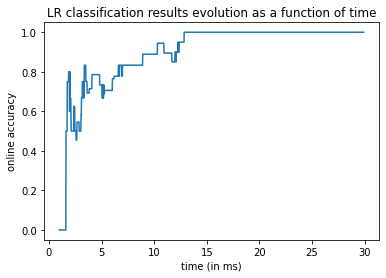

In [25]:
timestep = 10
meanac, onlinac, lastac, truepos, falsepos = score_classif_time(likelihood, true_target, timestamps, timestep, thres=None)

# Classification with histogram 

In [18]:
histo, label = fit_histo(hots)

Number of training samples: 48
load existing histograms


In [7]:
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
print(f'number of epochs: {num_epochs}')
ds_ev = 1
tau_cla = 1e4

number of epochs: 33


In [59]:
step = 0.05
namelist = ['raw','hots', 'homhots']
mean_acc = np.zeros([len(namelist),len(np.arange(0,1,step))])
last_acc = np.zeros([len(namelist),len(np.arange(0,1,step))])
true_positive = np.zeros([len(namelist),len(np.arange(0,1,step))])
false_positive = np.zeros([len(namelist),len(np.arange(0,1,step))])

for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            likelihood, true_target, time_scale = pickle.load(file)
    else:
        print(f'LR fit for {name}...')
        model, loss  = fit_data(name,timestr,record_path,filt,tau,R,nbclust,sigma,homeinv,jitter,dataset,nb_train,ds_ev, learning_rate, num_epochs,betas, tau_cla=tau_cla,jitonic=jitonic,subset_size=None,num_workers=num_workers,verbose=False)
        print(f'prediction for {name}...')
        likelihood, true_target, time_scale = predict_data(model,name,timestr,record_path,filt,tau,R,nbclust,sigma, homeinv,jitter,dataset,nb_test,ds_ev, tau_cla,jitonic=jitonic,subset_size=None,num_workers=num_workers, verbose=False)
        with open(f_name, 'wb') as file:
            pickle.dump([likelihood, true_target, time_scale], file, pickle.HIGHEST_PROTOCOL)
    
    thresnum = 0
    for thres in [None]:#np.arange(0,1,step):
        meanac, onlinac, lastac, truepos, falsepos = classification_results(likelihood, true_target, thres, nb_test)
        last_acc[namnum,thresnum] = lastac
        mean_acc[namnum,thresnum] = meanac
        true_positive[namnum,thresnum] = truepos
        false_positive[namnum,thresnum] = falsepos
        thresnum+=1

/home/antoine/homhots/HOTS/HOTS/Tools.py:497: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


In [13]:
print(np.mean(last_acc, axis=1))
print(np.mean(mean_acc, axis=1))

[0.05   0.05   0.0475]
[0.04923673 0.04950947 0.0470954 ]


In [38]:
print(last_acc[:,0])
print(mean_acc[:,0])

[1.   1.   0.95]
[0.98473461 0.99018944 0.941908  ]


In [15]:
def norm(x):
    x = np.array(x)
    x = (x-min(x))/(max(x)-min(x))
    return x

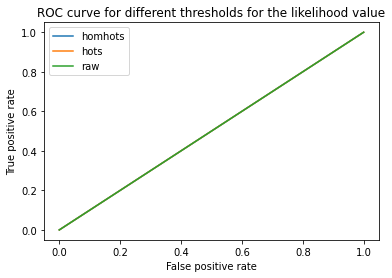

In [16]:
for i in range(3):
    plt.plot(norm(false_positive[i,:]), norm(true_positive[i,:]), label=namelist[i]);
plt.title('ROC curve for different thresholds for the likelihood value');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.legend();

In [17]:
from scipy.optimize import curve_fit
def fitting(x, a, b):
    #return a*np.tanh(x*b)
    return 1-np.exp(-(b*x)**a)

20


/home/antoine/homhots/HOTS/HOTS/Tools.py:526: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)
/home/antoine/homhots/HOTS/HOTS/Tools.py:526: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


20


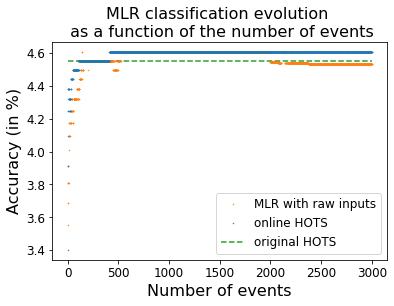

In [21]:
thres = None
colorz = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
legend_list = ['original HOTS', 'MLR with raw inputs', 'online HOTS']
namelist = ['raw', 'homhots']
fig_onl, ax_onl = plt.subplots()
ax_onl.hlines(np.log(95),0,3000, linestyles='dashed', color=colorz[2], label=legend_list[0])
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target, time_scale = pickle.load(file)
    meanac, onlinac, lastac, truepos, falsepos = classification_results(likelihood, true_target, thres, nb_test)
    #pars, cov = curve_fit(f=fitting, xdata=np.arange(len(onlinac)), ydata=onlinac, p0=[1,1], bounds=(-np.inf, np.inf))
    #fit = fitting(np.arange(len(onlinac)), *pars)
    ax_onl.plot(np.log(onlinac[:3000]*100), '.', ms=1, color=colorz[namnum], label = legend_list[namnum+1]);
    #ax_onl.plot(fit[:3000], linestyle='-', color=color[namnum], linewidth=1);
#ax_onl.axis([-50,3000,0,105]);
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
plt.setp(ax_onl.get_yticklabels(), fontsize=12)
plt.setp(ax_onl.get_xticklabels(), fontsize=12)
ax_onl.set_title('MLR classification evolution \n as a function of the number of events', fontsize=16);
ax_onl.legend(fontsize=12, loc='lower right');

In [16]:
printfig(fig_onl, 'poker_online.pdf')

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [17]:
LabelBinarizer().fit_transform(np.array(true_target))

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

<ipython-input-19-bf74f234c447>:31: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.axis([0,12,0.8,1.01]);


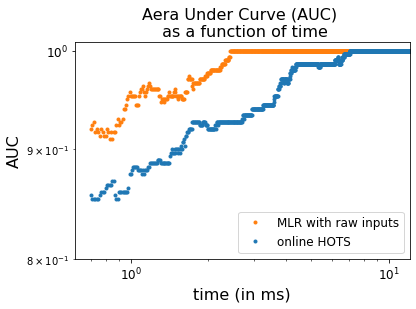

In [19]:
nb_classes = 4
timesteps = np.arange(700,12000,10)
namelist = ['raw', 'homhots']
leg_list = ['MLR with raw inputs', 'online HOTS']
colorz = ['#ff7f0e','#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target, time_scale = pickle.load(file)
    y_true = np.zeros([len(true_target)])
    y_score = np.zeros([len(true_target),nb_classes])
    proba_timestep = np.zeros([len(timesteps),len(true_target),nb_classes])
    i = 0
    for likelihood_, true_target_, time_scale_ in zip(likelihood, true_target, time_scale):
        time_scale_ -= time_scale_[0]
        previous_ind = 0
        for idx, step in enumerate(timesteps):
            ind = np.where(time_scale_<step)[0][-1]
            #proba = np.mean(likelihood_[previous_ind:ind,:], axis=0)
            proba = likelihood_[ind,:]
            if np.isnan(proba[0]):
                proba = proba_timestep[idx-1,i,:]
            proba_timestep[idx,i,:] = proba
        i+=1
    AUC = np.zeros([len(timesteps)])
    for idx, step in enumerate(timesteps):
        #print(proba_timestep[idx,:,:].shape, np.array(true_timestep[idx]))
        AUC[idx] = roc_auc_score(LabelBinarizer().fit_transform(np.array(true_target)),proba_timestep[idx,:,:], multi_class='ovr')
    ax.loglog(timesteps/1e3,AUC, '.', label=leg_list[namnum], color = colorz[namnum])
ax.axis([0,12,0.8,1.01]);
ax.set_xlabel('time (in ms)', fontsize=16);
ax.set_ylabel('AUC', fontsize=16);
ax.set_title('Aera Under Curve (AUC) \n as a function of time', fontsize=16);
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
ax.legend(fontsize=12, loc='lower right');

In [22]:
printfig(fig,'poker_auc.pdf')

# Paremeter testing

In [19]:
verbose=False
JS_score = []
JS_scorehom = []
JS_score_histav = []
JS_scorehom_histav = []
BA_score = []
BA_scorehom = []
BA_score_histav = []
BA_scorehom_histav = []
kNN6_score = []
kNN6_scorehom = []
kNN3_score = []
kNN3_scorehom = []

tauz = [0.01, 0.02, 0.05, 0.07, 0.08, 0.09, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 5, 10, 20, 30]

for name in ['hots', 'homhots']:
    for tau in tauz:
        hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
        #hotshom.plotlayer()
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histo', dataset=dataset, verbose=verbose)
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, dataset=dataset, verbose=verbose)
        
        score = histoscore(trainhistomap,testhistomap, verbose = verbose)
        if name=='hots':
            BA_score.append(score[0])
            JS_score.append(score[4])
            kNN3_score.append(score[5])
            kNN6_score.append(score[6])
        else:
            BA_scorehom.append(score[0])
            JS_scorehom.append(score[4])
            kNN3_scorehom.append(score[5])
            kNN6_scorehom.append(score[6])
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histav', dataset=dataset, verbose=verbose)
        score = histoscore_lagorce(trainhistomap,testhistomap, verbose = verbose)
        if name=='hots':
            BA_score_histav.append(score[0])
            JS_score_histav.append(score[4])
        else:
            BA_scorehom_histav.append(score[0])
            JS_scorehom_histav.append(score[4])

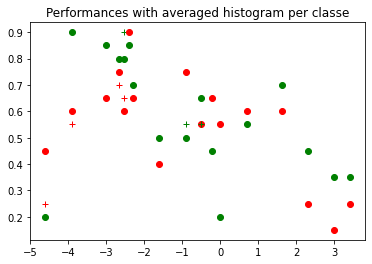

In [20]:
for i in range(len(tauz)):
    j = np.log(tauz[i])
    plt.plot(j,BA_score_histav[i], 'r +')
    plt.plot(j,JS_score_histav[i], 'r o')
    plt.plot(j,BA_scorehom_histav[i], 'g +')
    plt.plot(j,JS_scorehom_histav[i], 'g o')
    plt.title('Performances with averaged histogram per classe')

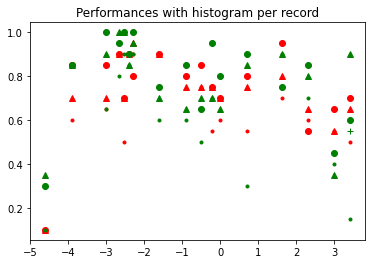

In [21]:
for i in range(len(tauz)):
    j = np.log(tauz[i])
    plt.plot(j,BA_score[i], 'r +')
    plt.plot(j,JS_score[i], 'r o')
    plt.plot(j,kNN3_score[i], 'r ^')
    plt.plot(j,kNN6_score[i], 'r .')
    plt.plot(j,BA_scorehom[i], 'g +')
    plt.plot(j,JS_scorehom[i], 'g o')
    plt.plot(j,kNN3_scorehom[i], 'g ^')
    plt.plot(j,kNN6_scorehom[i], 'g .')
    plt.title('Performances with histogram per record')